In [133]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

In [134]:
num_epochs = 10
batch_size = 100
learning_rate = 0.0001


In [135]:
batch_size

100

In [136]:
#텐서 설명 
t = np.array([[0., 1., 2., 3., 4., 5., 6.],[0., 1., 2., 3., 4., 5., 6.]])
print(t)

[[0. 1. 2. 3. 4. 5. 6.]
 [0. 1. 2. 3. 4. 5. 6.]]


In [137]:
print('Rank of t: ', t.ndim)
print('Shape of t: ', t.shape)
print(t[1])
print(t[1][:2])

Rank of t:  2
Shape of t:  (2, 7)
[0. 1. 2. 3. 4. 5. 6.]
[0. 1.]


In [138]:
device

device(type='cpu')

In [141]:
#저장할 디렉토리 
root = './EMNIST'
split= 'letters'


#학습할 프로세서 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#transform 설정 , mean 값을 빼준 값에 std 를 나눠줌 
#transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0,), std=(1,))])
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))])

#데이터 다운로드
train_data = dset.EMNIST(root=root,split=split, train=True, transform=transform, download=True)
test_data = dset.EMNIST(root=root, split=split, train=False, transform=transform, download=True)


#데이터를 학습에 맞는 형태로 묶어줌. batch_size 에 맞도록 
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)




In [122]:
#학습데이터 확인 
print(len(train_loader))
print(len(test_loader))
print(len(train_data))
print(len(test_data))

1248
208
124800
20800


In [123]:
#데이터 관찰 1
mean = 0.0
for i, (imgs, labels) in enumerate(train_loader):
    #mean += img.sum([1,2])/torch.numel(img[0])
    mean += imgs.mean()
mean = mean/i
print(mean)

tensor(-0.6561)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


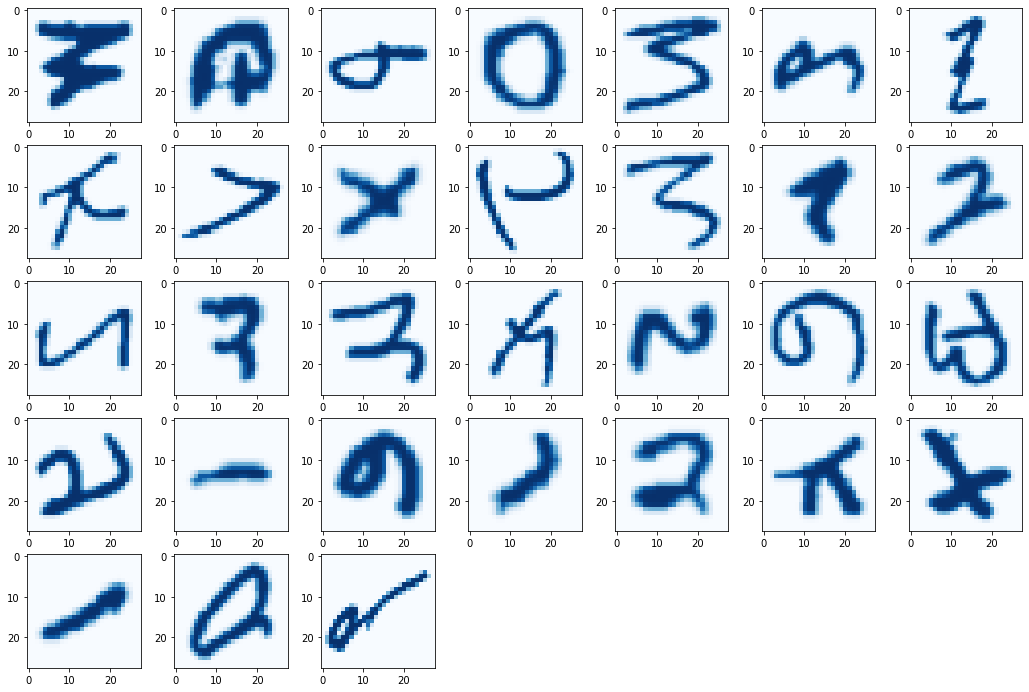

In [124]:
#데이터 관찰 2
fig = plt.figure(figsize=(18,100))

rows=40 
columns=7
for i, (imgs, labels) in enumerate(train_loader):
        print(i)
        
        imgs, labels = imgs.to(device), labels.to(device)
         
        #print( len(imgs))
        
        #print(imgs[0])
        #print( len(imgs[0,0]) )
        #print(imgs[0].mean())
        #print("labels")
        #print(labels)
        #print(labels.shape)
        #print(labels.dim())
        
        #input_img = train_data[i][0].unsqueeze(dim=0).to(device) 
        
        #print(input_img.size())
        #print(input_img.dim())
        #print(input_img.shape)
        #print(input_img.size())
        #print(input_img)
        fig.add_subplot(rows, columns, (i+1))
        plot_img = train_data[i][0][0]
        #print(plot_img)

        plt.imshow(plot_img,cmap='Blues')
        
        if i >= 30:
            break
        

In [125]:

#device = torch.device(device)
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.layer1 = nn.Sequential(
            torch.nn.Linear(784, 256, bias=True),
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            torch.nn.Linear(256, 64, bias=True),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU()
        )
        self.layer3 = nn.Sequential(
            torch.nn.Linear(64, 10, bias=True)
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten
        x_out = self.layer1(x)
        x_out = self.layer2(x_out)
        x_out = self.layer3(x_out)
        return x_out
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight) 
model = DNN().to(device)

#신경망 가중치 초기화 
model.apply(weights_init)

#로스계산 클래스 
criterion = torch.nn.CrossEntropyLoss().to(device)

#옵티마이저 (아담사용)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [126]:
#학습 
costs = []
total_batch = len(train_loader)

#epoch 반복 
for epoch in range(num_epochs):
    
    total_cost = 0
    
    #mini batch 반복 학습 
    for i, (imgs, labels) in enumerate(train_loader):
        #데이터 batch size 만큼 추출
        imgs, labels = imgs.to(device), labels.to(device)
        #예측실행 
        outputs = model(imgs)
        #예측과 정답 비교 후 loss 계산 
        loss = criterion(outputs, labels)
        
        #옵티마이저
        optimizer.zero_grad()
        
        #학습실행 
        loss.backward()
        optimizer.step()
        
        #로스율 취합 
        total_cost += loss
        
    #로스율 출력 
    avg_cost = total_cost / total_batch
    print("Epoch:", "%03d" % (epoch+1), "Cost =", "{:.9f}".format(avg_cost))  
    costs.append(avg_cost)            
    

IndexError: Target 23 is out of bounds.

In [ ]:
#테스트 데이터 전체에 모델돌려서 정답비교 후 결과 출력
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i, (imgs, labels) in enumerate(test_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, argmax = torch.max(outputs, 1)
        total += imgs.size(0)
        correct += (labels == argmax).sum().item()
    
    print('Accuracy for {} images: {:.2f}%'.format(total, correct / total * 100))                

In [84]:
#최종 출력 준비 


#plot에 보여줄 사이즈 
columns = 8
rows = 6


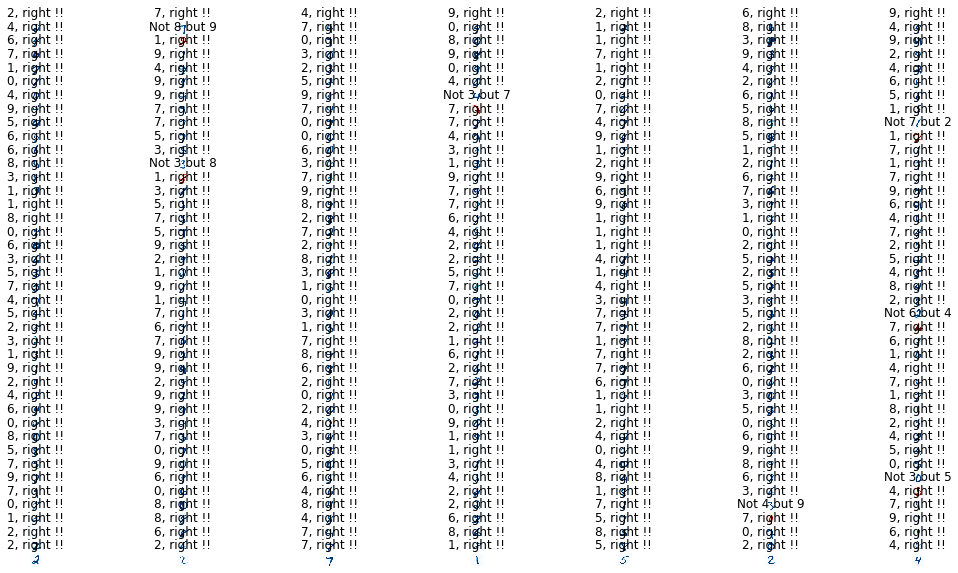

Accuracy for 280 images: 97.50%


In [61]:
#플롯설정 
fig = plt.figure(figsize=(18,10))
 
model.eval()
cnt = 0 
total_cnt =columns*rows
for i in range(1, columns*rows+1):
    #랜덤으로 테스트데이터에서 이미지 픽업 
    data_idx = np.random.randint(len(test_data))
    input_img = test_data[data_idx][0].unsqueeze(dim=0).to(device) 
 
    output = model(input_img)    
    _, argmax = torch.max(output, 1)
    
    
    #print(output)
    #output 에서 몇번째 값이 제일 확률적으로 높은지 표시    
    #print(argmax.item())
    
    pred = label_tags[argmax.item()]
    label = label_tags[test_data[data_idx][1]]
    
    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred + ', right !!')
        cmap = 'Blues'
        cnt = cnt +1
        #print("right")
    else:
        plt.title('Not ' + pred + ' but ' +  label)
        cmap = 'Reds'
        #print("error")
    plot_img = test_data[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap=cmap)
    plt.axis('off')
    
plt.show() 

print('Accuracy for {} images: {:.2f}%'.format(total_cnt, cnt / total_cnt * 100))  

In [25]:
torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, "model/model_mnist.pt")

torch.save(model.state_dict(), "model/model_mnist_min.pt")

FileNotFoundError: [Errno 2] No such file or directory: 'model/model_mnist.pt'

In [124]:
PATH = "model/model.pt"

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()

DNN(
  (layer1): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=True)
  )
)